In [101]:
# 데이터 호출 및 전처리 도구
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.tsa.stattools import adfuller, kpss # 시계열 데이터 정상성 검정 도구

# 딥러닝 도구
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

#시각화 도구
import matplotlib.pyplot as plt
import seaborn as sns

# 시드 고정
torch.manual_seed(0)

# 하이퍼 파라미터 설정
params = {
    'train_ratio' : 0.7,
    'seq_length' : 7,
    'learning_rate': 1e-2,
}

import warnings
warnings.simplefilter(action='ignore', category=[FutureWarning]) # FutureWarning 제거

# 정상성 검정

In [92]:
df = pd.read_csv('/content/drive/MyDrive/빅쿼리 결과/thelook_ecommerce.csv')
df = df[df['date'] < '2023']
df.head()

,date,joined_users
0,2019-01-02 00:00:00 UTC,60
1,2019-01-03 00:00:00 UTC,67
2,2019-01-04 00:00:00 UTC,63
3,2019-01-05 00:00:00 UTC,72
4,2019-01-06 00:00:00 UTC,57


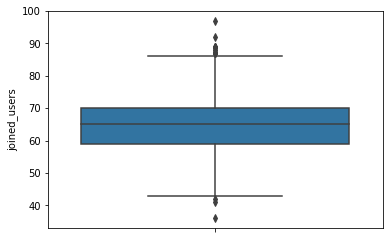

In [93]:
sns.boxplot(data=df, y='joined_users')

In [94]:
from IPython.display import display

def adf_test(data, p_val = .05, regression_option = 'ct'):
  dftest = adfuller(data, autolag='AIC', regression = regression_option)
  dfout = pd.Series(dftest[:4], index=['Test Statistic', 'P-value', 'Lags Used', 'Observations Used'])

  for k, v in dftest[4].items():
    dfout['Critical Value (%s)'%k] = v
  
  display(pd.DataFrame(dfout, columns=['Value']))

  if dfout[1] < p_val:
    print(f"{dfout[1]} < {p_val}로 귀무가설을 기각합니다. 본 데이터는 정상 시계열 데이터 입니다.")
    return True
  else:
    print(f"{dfout[1]} > {p_val}로 귀무가설을 채택합니다. 본 데이터는 비정상 시계열 데이터 입니다.")
    return False

In [95]:
adf_test(df['joined_users'])

,Value
Test Statistic,-28.688895
P-value,0.000000
Lags Used,1.000000
Observations Used,1458.000000
Critical Value (1%),-3.964993
Critical Value (5%),-3.413506
Critical Value (10%),-3.128825


0.0 < 0.05로 귀무가설을 기각합니다. 본 데이터는 정상 시계열 데이터 입니다.


True

In [96]:
def kpss_test(data, p_val=.05, regression_option='ct'):
  _kpss = kpss(data, regression = regression_option)
  kpss_out = pd.Series(_kpss[:3], index =['Test Statistic', 'P-value', 'Lags Used'])

  for k, v in _kpss[3].items():
    kpss_out['Critical_value (%s)'%k] = v
  
  display(pd.DataFrame(kpss_out, columns=['Value']))

  if kpss_out[1] < p_val:
    print(f"{kpss_out[1]} < {p_val}로 귀무가설을 기각합니다. 본 데이터는 비정상 시계열 데이터 입니다.")
    return False
  else:
    print(f"{kpss_out[1]} > {p_val}로 귀무가설을 채택합니다. 본 데이터는 정상 시계열 데이터 입니다.")
    return True

In [97]:
kpss_test(df['joined_users'])

,Value
Test Statistic,0.145588
P-value,0.050762
Lags Used,24.000000
Critical_value (10%),0.119000
Critical_value (5%),0.146000
Critical_value (2.5%),0.176000
Critical_value (1%),0.216000


0.05076210860506094 > 0.05로 귀무가설을 채택합니다. 본 데이터는 정상 시계열 데이터 입니다.


True

1     7.0
2    -4.0
3     9.0
4   -15.0
5    20.0
Name: joined_users, dtype: float64

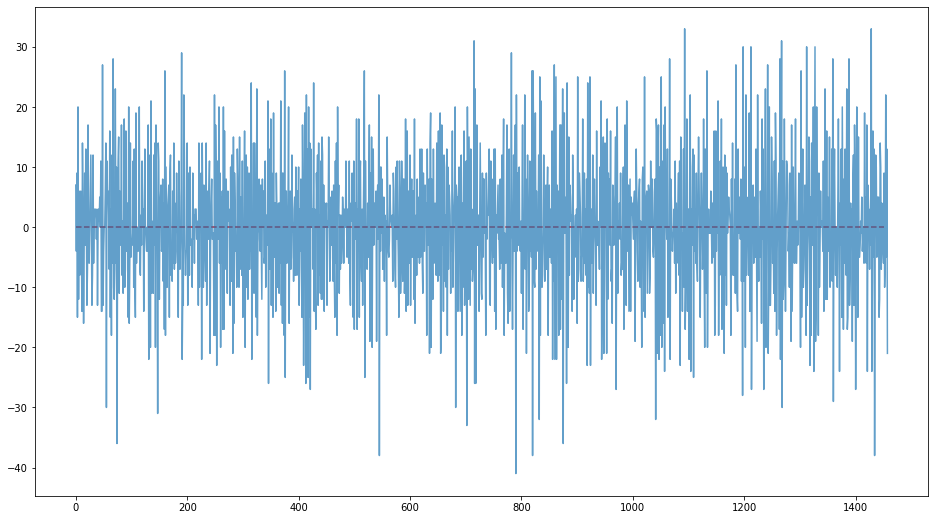

In [98]:
# 차분을 통한 데이터 정상화
_diff = df['joined_users'].diff(1).dropna()[:-1]
display(_diff.head())

plt.figure(figsize=(16,9))
plt.plot(_diff.values, alpha=.7)
plt.hlines(y=_diff.mean(), xmin = 0, xmax=1450 , color='red', linestyle='--')
plt.show()

In [99]:
print(adf_test(_diff))
print(kpss_test(_diff))

,Value
Test Statistic,-1.282588e+01
P-value,2.297952e-20
Lags Used,2.400000e+01
Observations Used,1.433000e+03
Critical Value (1%),-3.965101e+00
Critical Value (5%),-3.413558e+00
Critical Value (10%),-3.128856e+00


2.297951713327525e-20 < 0.05로 귀무가설을 기각합니다. 본 데이터는 정상 시계열 데이터 입니다.
True


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


,Value
Test Statistic,0.009763
P-value,0.100000
Lags Used,24.000000
Critical_value (10%),0.119000
Critical_value (5%),0.146000
Critical_value (2.5%),0.176000
Critical_value (1%),0.216000


0.1 > 0.05로 귀무가설을 채택합니다. 본 데이터는 정상 시계열 데이터 입니다.
True


# 모델 설계

## 데이터 호출 및 확인

In [69]:
df = pd.read_csv('/content/drive/MyDrive/빅쿼리 결과/thelook_ecommerce.csv')
df.head()

,date,joined_users
0,2019-01-02 00:00:00 UTC,60
1,2019-01-03 00:00:00 UTC,67
2,2019-01-04 00:00:00 UTC,63
3,2019-01-05 00:00:00 UTC,72
4,2019-01-06 00:00:00 UTC,57


In [70]:
df = df[df['date'] < '2023']
df

,date,joined_users
0,2019-01-02 00:00:00 UTC,60
1,2019-01-03 00:00:00 UTC,67
2,2019-01-04 00:00:00 UTC,63
3,2019-01-05 00:00:00 UTC,72
4,2019-01-06 00:00:00 UTC,57
...,...,...
1455,2022-12-27 00:00:00 UTC,72
1456,2022-12-28 00:00:00 UTC,67
1457,2022-12-29 00:00:00 UTC,80
1458,2022-12-30 00:00:00 UTC,59


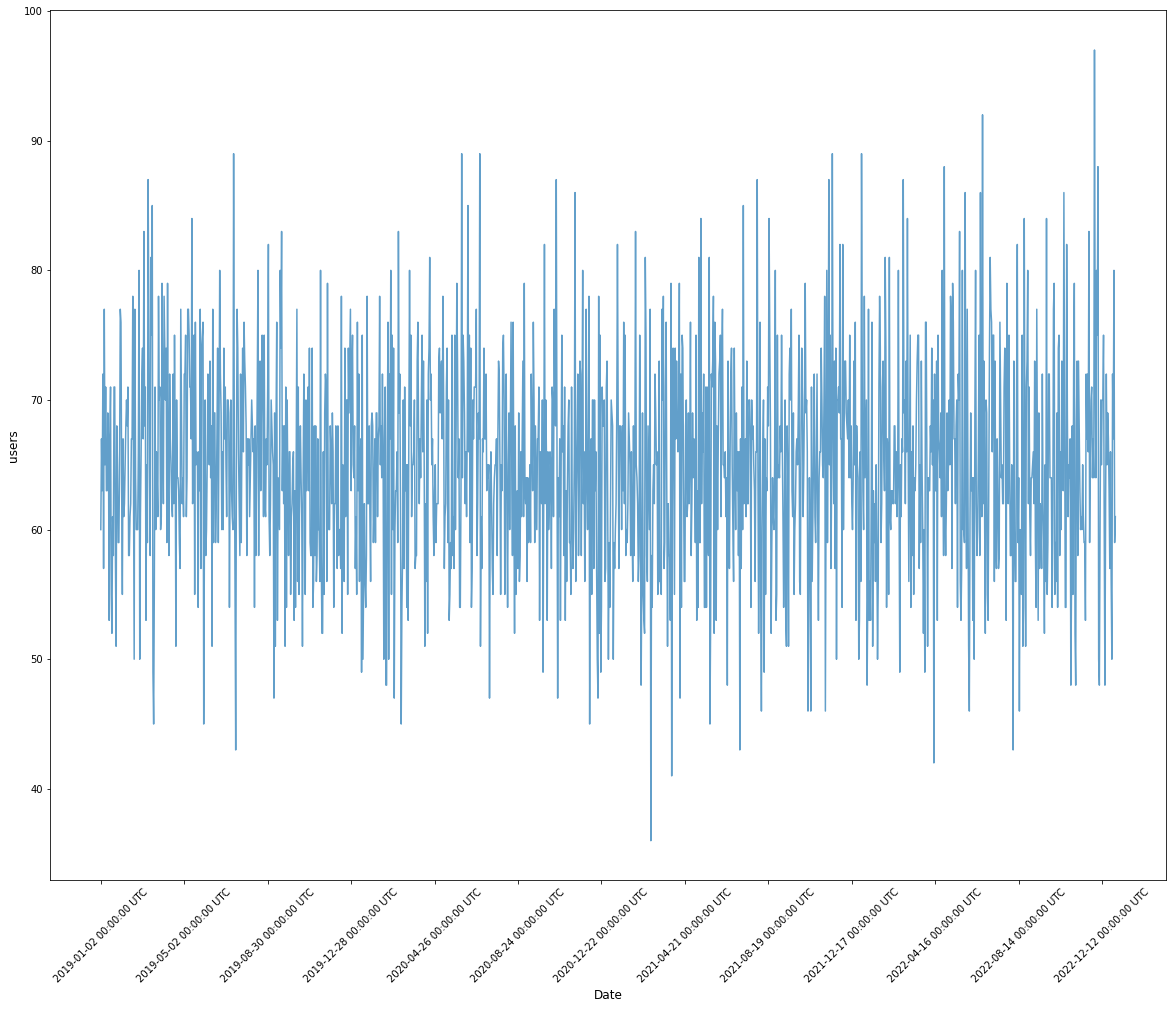

In [71]:
plt.figure(figsize = (20, 16))
plt.plot(range(df.shape[0]), df['joined_users'], alpha=.7)
plt.xticks(range(0, df.shape[0], 120), df['date'].loc[::120], rotation=45)
plt.xlabel('Date', fontsize=12)
plt.ylabel('users', fontsize=12)
plt.show()

## 데이터 전처리

In [72]:
scaler = StandardScaler()

data = scaler.fit_transform(df.iloc[:,1:2].values)
data[:2]

array([[-0.60280542],
       [ 0.24344065]])

In [73]:
# seq_length 기간 동안의 데이터로 예측
def data_label_split(data, seq_length):
  x = []
  y = []

  for i in range(len(data) - seq_length-1):
    _x = data[i:(i+seq_length)]
    _y = data[i+seq_length]
    x.append(_x)
    y.append(_y)

  return np.array(x), np.array(y)

In [74]:
train_size = int(len(data)*params['train_ratio'])

x, y = data_label_split(data, params['seq_length'])

train_x = Variable(torch.FloatTensor(x[:train_size]), requires_grad=True)
train_y = Variable(torch.FloatTensor(y[:train_size]), requires_grad=True)

test_x = Variable(torch.FloatTensor(x[train_size:]), requires_grad=True)
test_y = Variable(torch.FloatTensor(y[train_size:]), requires_grad=True)

train_x.size()

torch.Size([1021, 7, 1])

## 모델 정의

In [84]:
class myLSTM(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers):
    super(myLSTM, self).__init__()
    
    self.num_classes = num_classes
    self.num_layers = num_layers
    self.input_size = input_size
    self.hidden_size= hidden_size
    self.seq_length = params['seq_length']

    self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                        num_layers = num_layers, batch_first = True)
    
    self.fc1 = nn.Linear(hidden_size, 256)
    self.fc2 = nn.Linear(256, 256)
    self.fc3 = nn.Linear(256, 128)
    self.fc4 = nn.Linear(128, num_classes)

    self.relu = nn.ReLU()

  
  def forward(self, x):
    h_0 = Variable(torch.zeros(
        self.num_layers, x.size(0), self.hidden_size
    ))

    c_0 = Variable(torch.zeros(
        self.num_layers, x.size(0), self.hidden_size
    ))

    ula, (h_out, _) = self.lstm(x, (h_0, c_0))
    h_out = h_out.view(-1, self.hidden_size)

    out = self.relu(h_out)
    out = self.fc1(out)
    out = self.relu(out)
    out = self.fc2(out)
    out = self.relu(out)
    out = self.fc3(out)
    out = self.relu(out)
    out = self.fc4(out)

    return out

In [85]:
nb_epochs = 2000

input_size = 1
hidden_size = 7
num_layers = 1
num_classes = 1

model = myLSTM(num_classes, input_size, hidden_size, num_layers)

# Run!!

In [86]:
# Loss function = MSE, Optimizer = Adam
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])

for epoch in range(nb_epochs+1):
  outputs = model(train_x)
  optimizer.zero_grad()

  loss = criterion(outputs, train_y)
  loss.backward()

  optimizer.step()
  if epoch % 100 == 0:
    print(f'Epoch: {epoch}/{nb_epochs}, loss: {loss.item()}')

Epoch: 0/2000, loss: 0.9369269013404846
Epoch: 100/2000, loss: 0.8638815879821777
Epoch: 200/2000, loss: 0.755851149559021
Epoch: 300/2000, loss: 0.7005799412727356
Epoch: 400/2000, loss: 0.5064218044281006
Epoch: 500/2000, loss: 0.41919785737991333
Epoch: 600/2000, loss: 0.3797298073768616
Epoch: 700/2000, loss: 0.3054530918598175
Epoch: 800/2000, loss: 0.2814027965068817
Epoch: 900/2000, loss: 0.2714000940322876
Epoch: 1000/2000, loss: 0.21534167230129242
Epoch: 1100/2000, loss: 0.21595539152622223
Epoch: 1200/2000, loss: 0.23493532836437225
Epoch: 1300/2000, loss: 0.19605180621147156
Epoch: 1400/2000, loss: 0.1718875914812088
Epoch: 1500/2000, loss: 0.1680368334054947
Epoch: 1600/2000, loss: 0.17607055604457855
Epoch: 1700/2000, loss: 0.20787383615970612
Epoch: 1800/2000, loss: 0.13136029243469238
Epoch: 1900/2000, loss: 0.1349521428346634
Epoch: 2000/2000, loss: 0.1469685137271881


# 평가 및 결과 시각화

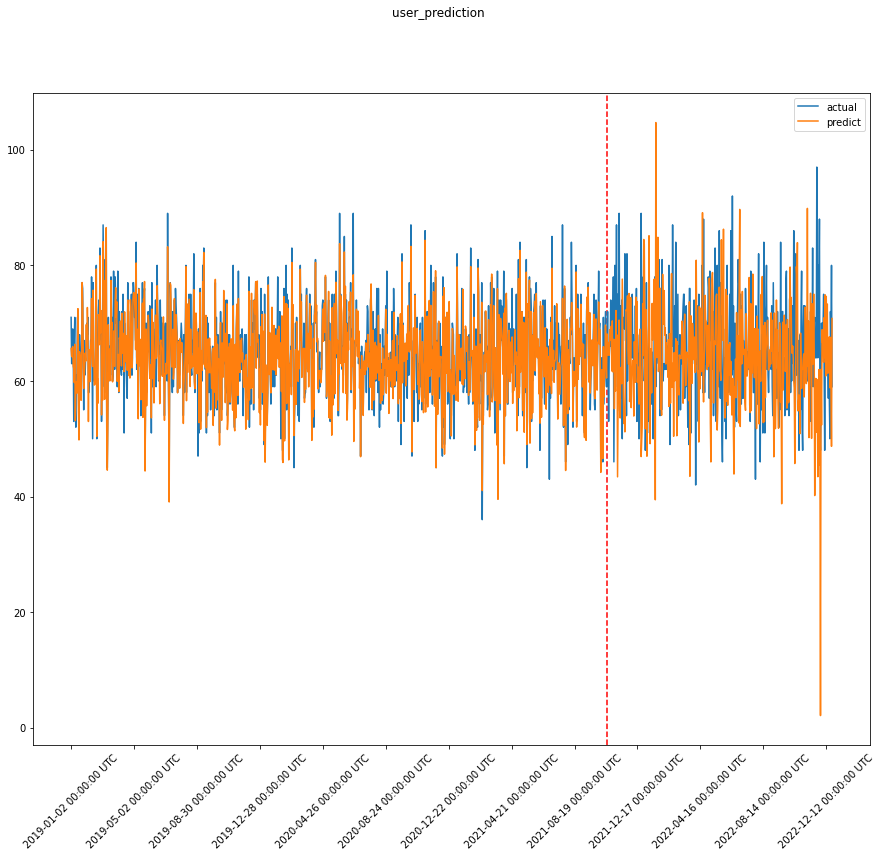

7.692684


In [88]:
from sklearn.metrics import mean_squared_error

with torch.no_grad():
  model.eval()
  x = Variable(torch.FloatTensor(x), requires_grad=True)
  y = Variable(torch.FloatTensor(y), requires_grad=True)
  validation = model(x)

  _pred = validation.data.numpy()
  _label = y.data.numpy()

  pred = scaler.inverse_transform(_pred)
  label = scaler.inverse_transform(_label)

  rmse = np.sqrt(mean_squared_error(pred, label))

  plt.figure(figsize=(15,12))
  plt.axvline(x=train_size, c='r', linestyle='--')

  plt.plot(label, label='actual')
  plt.plot(pred, label='predict')

  plt.suptitle('user_prediction')
  plt.xticks(range(0, df.shape[0], 120), df['date'].loc[::120], rotation=45)
  plt.legend()

  plt.show()

  print(rmse)

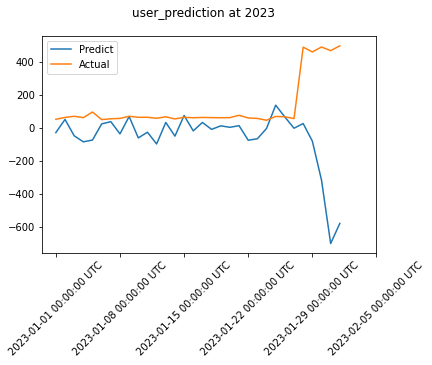

In [90]:
origin = pd.read_csv('/content/drive/MyDrive/빅쿼리 결과/thelook_ecommerce.csv')
data_2023 = origin['2023' < origin['date']]
data_2023 = data_2023.iloc[:,1:2].values

data_2023 = scaler.fit_transform(data_2023)

x_2023, y_2023 = data_label_split(data_2023, 7)
x_2023 = Variable(torch.FloatTensor(x_2023))
y_2023 = Variable(torch.FloatTensor(y_2023))

with torch.no_grad():
  model.eval()
  prediction = model(x_2023)
  prediction = prediction.data.numpy()

  actual = y_2023.data.numpy()

  prediction = scaler.inverse_transform(prediction)
  actual = scaler.inverse_transform(actual)

  plt.plot(prediction, label='Predict')
  plt.plot(actual, label='Actual')

  plt.xticks(range(0, origin['2023' < origin['date']]['date'].shape[0], 7), origin['2023' < origin['date']]['date'].loc[::7], rotation=45)

  plt.suptitle('user_prediction at 2023')
  plt.legend(loc='best')
  plt.show()